# Präsenzversuch zum Laval-Rotor

Name: Maurizio Fell
Datum: 02.02.2024
Gruppe: 25

## Forschungsfrage

Beim Laborversuch haben wir in der Gruppe versucht herauszufinden, welche kritische Drehzahl unser Laval-Rotor Prüfstand hat. Wird sich unsere analytisch ermittelte Drehzahl für den Prüfstand anhand des Campbell Diagramms, das in dieser Ausarbeitung erstellt wird, bestätigen? 

## Erster Versuch: Prüfstand #3


###  Versuchsaufbau
- Bild des Prüfstands:

<img src="bilder/stand3.jpeg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Zu sehen ist der Laval-Rotor Prüfstand 3 mit einer 950g schweren Scheibe, die in der Mitte angebracht ist. An den Enden der Welle ist ein Lager angebracht. Der Motor ist am rechten Ende montiert. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten



##### 1.a) Angabe der Pfade und Dateinamen


In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_140945_lavalrotor_25_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_140945_lavalrotor_25_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten


In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#### 2. Verarbeitung der Messdaten



In [5]:
importlib.reload(m_postprocessing)  # reload functions
dataset_path = "{}/{}".format(path_measurement_folder,filename )
f = h5py.File(dataset_path, "r")
#Erstellen von listtime und listbetrag, worin timestamps und Beträge der Beschleunigungen gespeichert sind
listbetrag = []
listtime = []
for ii in range(len(f.keys())):
    arraytime = np.array(f[str(ii)]["RawData"][uuid_acceleration]["timestamp"])
    arrayx = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])
    arrayy = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])
    arrayz = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])
    listbetrag.append(m_postprocessing.get_vec_accel(arrayx,arrayy,arrayz))
    listtime.append(arraytime)


In [6]:
#Verschiebung des Mittelwerts für alle Beschleunigungs-Datensätze, sodass der Mittelwert bei 0 m/s^2 liegt
listmeanbetrag = []
listbetragneu = []
for i in range(len(f.keys())):
    meanbetrag = np.mean(listbetrag[i])
    listmeanbetrag.append(meanbetrag)
    betragneu = listbetrag[i]-listmeanbetrag[i]
    listbetragneu.append(betragneu)
    
#Durchführen der Interpolation und FFT 
listinterpol = []
for i in range(len(f.keys())):
    listinterpol.append(m_postprocessing.interpolation(listtime[i], listbetragneu[i], interpolation_points))
listfft = []
for i in range(len(f.keys())):
    listfft.append(m_postprocessing.my_fft_scaled(listinterpol[i],interpolation_points))
    

#### 3. Darstellung mittels Campbell-Diagramm


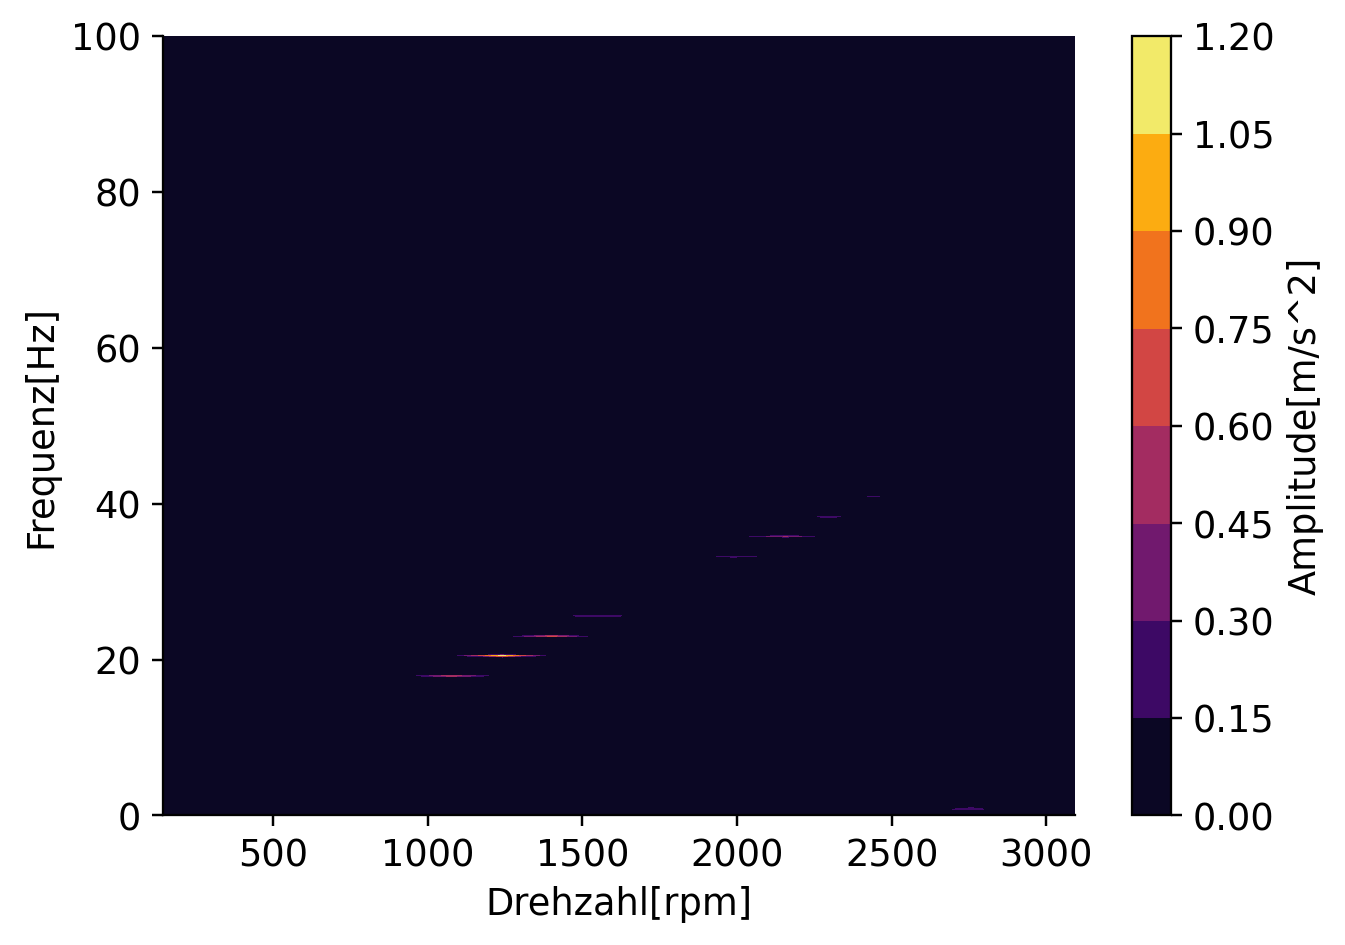

In [7]:
#Erstellen von listrpm, listfreq und listampgesamt, worin die Drehzahlen, die Frequenzen und die Amplituden der Datensätze gespeichert sind
listrpm3 = []
for i in range(len(f.keys())):
    listrpm3.append(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
listampgesamt = []
for i in range(len(f.keys())):
    listamp = []
    for ii in range(len(listfft[0][0])):
        listamp.append(listfft[i][0][ii])
    listampgesamt.append(listamp)
listfreq = []
for i in range(len(listfft[0][0])):
    listfreq.append(listfft[0][1][i])
#Erstellen des Campbelldiagramms mit einem meshgrid aus Rpm-und Frequenzdaten und z-Werten aus den Amplitudendaten
amparray3 = np.array(listampgesamt)
x,y = np.meshgrid(listrpm3, listfreq)
z = np.transpose(amparray3)
fig , ax = plt.subplots(1,1)
im = ax.contourf(x,y,z, cmap = "inferno")
ax.set_ylim(0,100)
xlab = "Drehzahl[rpm]"
ylab = "Frequenz[Hz]"
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
fig.colorbar(im,label="Amplitude[m/s^2]")



## Zweiter Datensatz: Prüfstand #2

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing)  # reload functions
dataset_path = "{}/{}".format(path_measurement_folder,filename )
f = h5py.File(dataset_path, "r")

listbetrag = []
listtime = []
for ii in range(len(f.keys())):
    arraytime = np.array(f[str(ii)]["RawData"][uuid_acceleration]["timestamp"])
    arrayx = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])
    arrayy = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])
    arrayz = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])
    listbetrag.append(m_postprocessing.get_vec_accel(arrayx,arrayy,arrayz))
    listtime.append(arraytime)
listmeanbetrag = []
listbetragneu = []
for i in range(len(f.keys())):
    meanbetrag = np.mean(listbetrag[i])
    listmeanbetrag.append(meanbetrag)
    betragneu = listbetrag[i]-listmeanbetrag[i]
    listbetragneu.append(betragneu)
    


listinterpol = []
for i in range(len(f.keys())):
    listinterpol.append(m_postprocessing.interpolation(listtime[i], listbetragneu[i], interpolation_points))
listfft = []
for i in range(len(f.keys())):
    listfft.append(m_postprocessing.my_fft_scaled(listinterpol[i],interpolation_points))
    



#### 3. Darstellung mittels Campbell-Diagramm

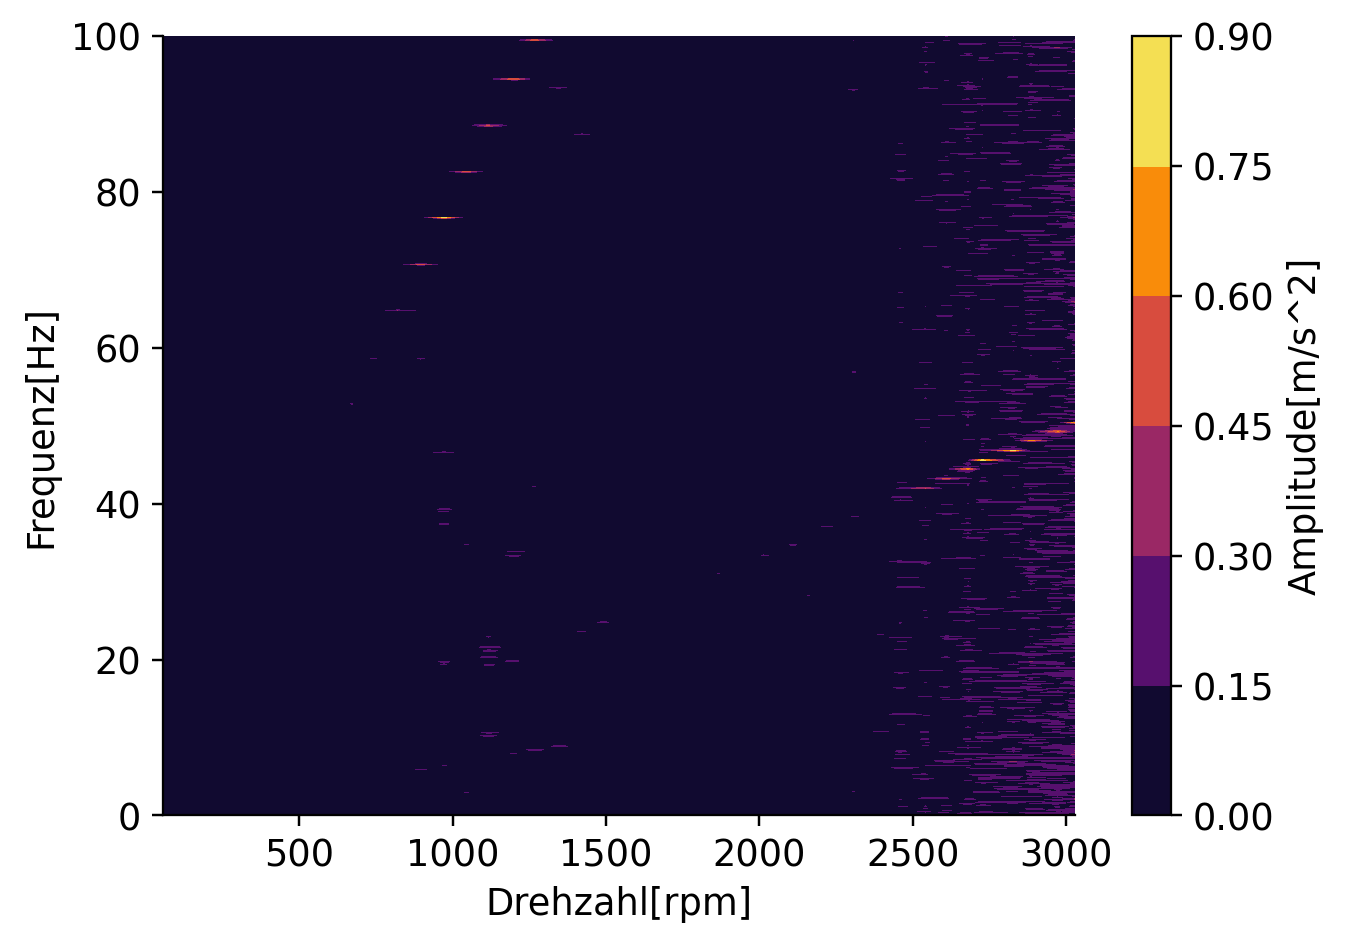

In [10]:
listrpm = []
for i in range(len(f.keys())):
    listrpm.append(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
listampgesamt = []
for i in range(len(f.keys())):
    listamp = []
    for ii in range(len(listfft[0][0])):
        listamp.append(listfft[i][0][ii])
    listampgesamt.append(listamp)
listfreq = []
for i in range(len(listfft[0][0])):
    listfreq.append(listfft[0][1][i])

amparray = np.array(listampgesamt)

x,y = np.meshgrid(listrpm, listfreq)
z = np.transpose(amparray)
fig , ax = plt.subplots(1,1)
im = ax.contourf(x,y,z, cmap = "inferno")
ax.set_ylim(0,100)
xlab = "Drehzahl[rpm]"
ylab = "Frequenz[Hz]"
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
fig.colorbar(im,label="Amplitude[m/s^2]")

## Dritter Datensatz: Prüfstand #4

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing)  # reload functions
dataset_path = "{}/{}".format(path_measurement_folder,filename )
f = h5py.File(dataset_path, "r")

listbetrag = []
listtime = []
for ii in range(len(f.keys())):
    arraytime = np.array(f[str(ii)]["RawData"][uuid_acceleration]["timestamp"])
    arrayx = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])
    arrayy = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])
    arrayz = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])
    listbetrag.append(m_postprocessing.get_vec_accel(arrayx,arrayy,arrayz))
    listtime.append(arraytime)
listmeanbetrag = []
listbetragneu = []
for i in range(len(f.keys())):
    meanbetrag = np.mean(listbetrag[i])
    listmeanbetrag.append(meanbetrag)
    betragneu = listbetrag[i]-listmeanbetrag[i]
    listbetragneu.append(betragneu)

listinterpol = []
for i in range(len(f.keys())):
    listinterpol.append(m_postprocessing.interpolation(listtime[i], listbetragneu[i], interpolation_points))
listfft = []
for i in range(len(f.keys())):
    listfft.append(m_postprocessing.my_fft_scaled(listinterpol[i],interpolation_points))
    

#### 3. Darstellung mittels Campbell-Diagramm

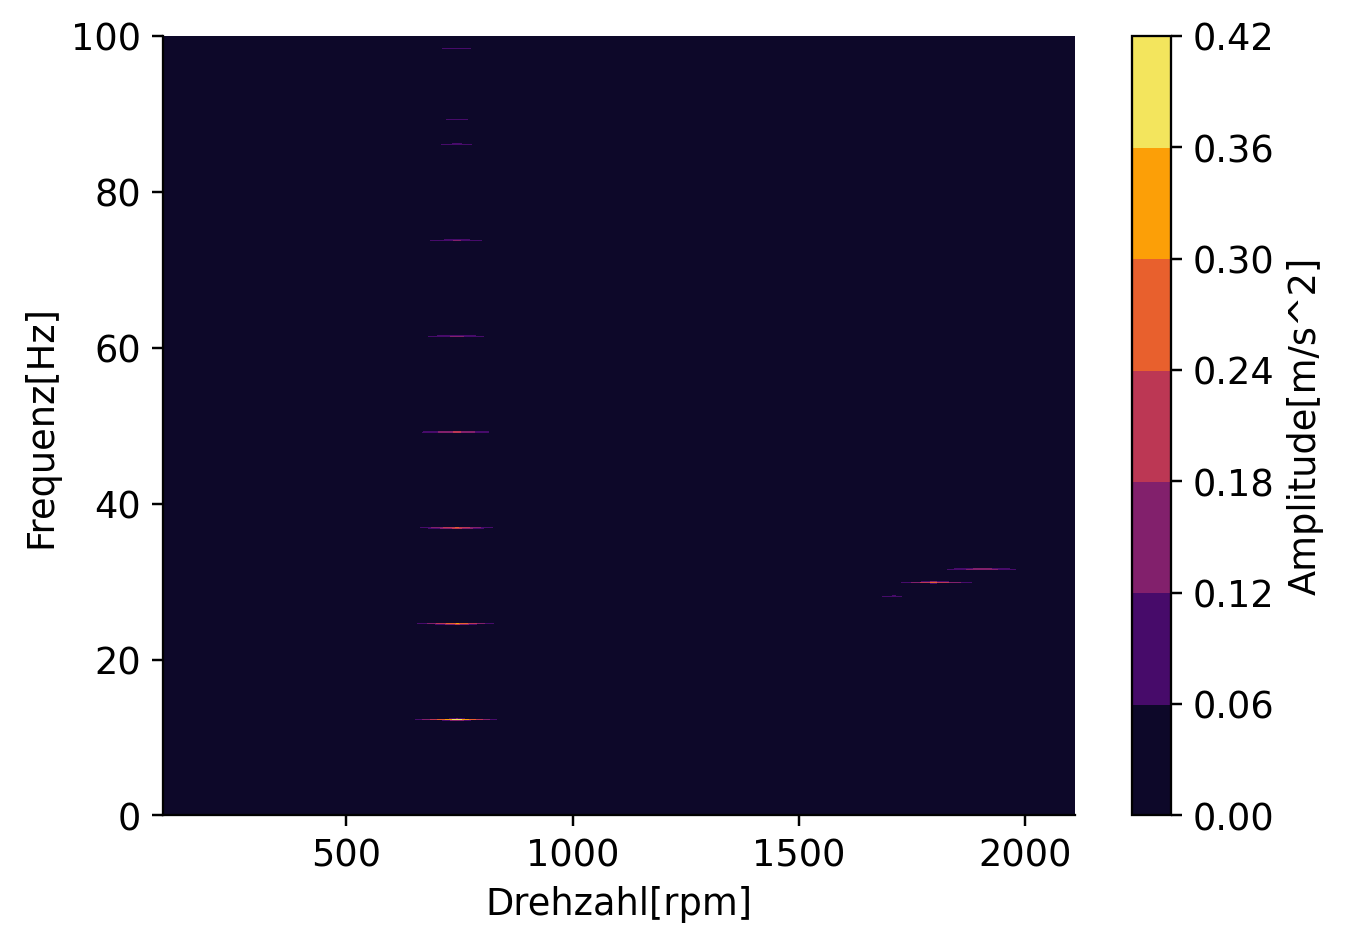

In [13]:
listrpm = []
for i in range(len(f.keys())):
    listrpm.append(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
listampgesamt = []
for i in range(len(f.keys())):
    listamp = []
    for ii in range(len(listfft[0][0])):
        listamp.append(listfft[i][0][ii])
    listampgesamt.append(listamp)
listfreq = []
for i in range(len(listfft[0][0])):
    listfreq.append(listfft[0][1][i])

amparray = np.array(listampgesamt)

x,y = np.meshgrid(listrpm, listfreq)
z = np.transpose(amparray)
fig , ax = plt.subplots(1,1)
im = ax.contourf(x,y,z, cmap="inferno")
ax.set_ylim(0,100)
xlab = "Drehzahl[rpm]"
ylab = "Frequenz[Hz]"
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
fig.colorbar(im,label="Amplitude[m/s^2]")



## Diskussion
Prüfstand 3: Der dritte Prüfstand ist der, an dem wir in der Gruppe die Messung durchgeführt haben und der nur eine Scheibe besitzt. Wie man anhand des Campbell Diagramms sieht, hat man in einem Drehzahlbereich von etwa 1200 bis 1300 rpm höhere Amplituden bei einer Fequenz von ca. 20 Hz. Zu erkennen ist beim Prüfstand 3 auch die Selbstzentrierung, da es kaum bemerkbare Amplitudenerhöhungen in höheren Drehzahlbereichen gibt. Der Prüfstand 3 ist allgemein sehr stabil und hat auch beim Präsenzversuch kaum Geräusche gemacht. Die Vibrationen waren auch gering im Vergleich zu den anderen Prüfständen vorort. 

Prüfstand 2: Der zweite Prüfstand hat zwei Scheiben. Am Campbell Diagramm sieht man, dass es viel mehr Drehzahlen gibt, bei denen es zu starken Vibrationen kommt. Auffällig ist auch das starke Rauschen über den gesamten Frequenzbereich im hohen Drehzahlbereich. Eine Selbstzentrierung im hohen Drezahlbereich ist nicht zu erkennen, da auch in den hohen Drehzahlbereichen kritische Bereiche bei 2500 bis 3000 rpm zu sehen sind. Aufgrund der vielen Vibrationen und des Rauschens im hohen Drehzahlbereich, kann man erahnen, dass der Prüfstand nicht besonders stabil ist.

Prüfstand 4: Der vierte Prüfstand hat wieder nur eine Scheibe. Am Campbell Diagramm sieht man, dass es besonders bei der Drehzahl ca. 750 rpm zu erhöhten Amplituden über mehrere Frequenzen kommt. Auch im Bereich 1750 bis 2000 rpm kommt es bei etwa 30 Hz zu hohen Amplituden. Ansonsten sind keine weiteren merkbaren Amplituden zu erkennen. Zum Ende hin bei Drehzahlen über 2000 rpm sind gar keine Vibrationen zu erkennen, was darauf hinweist, dass sich der Rotor hier selbst stabilisiert. Der Prüfstand ist also auch relativ stabil. 

In [14]:
#Ermitteln der gemessenen kritischen Drehzahl für Prüfstand 3

listkritamp = []
for i in range(len(amparray3)):
    kritamp = max(amparray3[i])
    listkritamp.append(kritamp)
index = listkritamp.index(max(listkritamp))  
Nkrit = listrpm3[index]
print("Nkrit = ",Nkrit,"rpm")

Nkrit =  1240 rpm


##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl

Bei unserer analytischen Berechnung der kritischen Drehzahl, kamen wir auf den Wert 17.69 Hz bzw. 1061,4 rpm. 
Die gemessene kritische Drehzahl Nkrit liegt bei 1240 rpm und weicht somit um ca. 16% vom analytischen Wert ab. Diese relativ geringe Abweichung ist damit zu erklären, dass in der Realität die Eigenschaften des Prüfstandes 3, wie zum Beispiel die Dichteverteilung der Scheibe oder der E-Modul, nicht genau den angegeben Werten entsprechen. 

## Fazit
Dieser Laborversuch hat mir persönlich Spaß gemacht. Ich habe das Campbell Diagramm kennengelernt, welches für mich erst ein Rätsel darstellte, und verstanden welchen Nutzen es hat. Außderdem war die Ausarbeitung etwas kniffliger, da man für das Campbell Diagramm keine spezifische Anweisung bekommen hat und selbst herausfinden musste wie man es erzeugt. 